In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import r2_score
import plotnine as pt

# Intro

In [2]:
baseball = pd.read_csv("/Users/williamkapner/Documents/GSB_544/Data/Hitters.csv")
baseball.dropna(inplace=True)
baseball

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [3]:
def rsqcoef(X,y,pipeline, type):
    lr_fitted = pipeline.fit(X, y)


    # Predictions for train and test sets
    y_test_pred = lr_fitted.predict(X)

    r2 = r2_score(y, y_test_pred)
    intercept = lr_fitted.named_steps[f"{type}_regression"].intercept_
    coefficients = lr_fitted.named_steps[f"{type}_regression"].coef_
    feature_names = X.columns if hasattr(X, 'columns') else [f"Feature {i}" for i in range(len(coefficients))]
    
    preprocessing = lr_fitted.named_steps['preprocessing']
    if hasattr(preprocessing, 'get_feature_names_out'):
        feature_names = preprocessing.get_feature_names_out()
    else:
        feature_names = [f"Feature {i}" for i in range(len(coefficients))]

    # Create a labeled table for coefficients
    coef_table = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })



    return r2, intercept, coef_table

# Part 1: Different Model Specs

## A. Regression without regularization

In [5]:
X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]

In [107]:
ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)


lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")


rsqcoef(X,y,lr_pipeline,"linear")

(0.5461158619125321,
 537.9273144423056,
                  Feature  Coefficient
 0      dummify__League_A   -31.299712
 1      dummify__League_N    31.299712
 2    dummify__Division_E    58.424623
 3    dummify__Division_W   -58.424623
 4   dummify__NewLeague_A    12.381163
 5   dummify__NewLeague_N   -12.381163
 6     standardize__AtBat  -291.094556
 7      standardize__Hits   337.830479
 8     standardize__HmRun    37.853837
 9      standardize__Runs   -60.572479
 10      standardize__RBI   -26.994984
 11    standardize__Walks   135.073897
 12    standardize__Years   -16.693359
 13   standardize__CAtBat  -391.038655
 14    standardize__CHits    86.687617
 15   standardize__CHmRun   -14.181723
 16    standardize__CRuns   480.747135
 17     standardize__CRBI   260.689886
 18   standardize__CWalks  -213.892259
 19  standardize__PutOuts    78.761296
 20  standardize__Assists    53.732490
 21   standardize__Errors   -22.160862)

2. For this model, the R-Squared value is 0.546. Players in the American league before 1987 make about 31.3 thousand dollars less than average. For every additional RBI a player had in 1986, he makes about 27 thousand dollars less. For every additional error a player makes in his career, he will make 22.16 thousand dollars less.

In [108]:
cross_val_score(lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()

-120656.57125044877

3. The cross validation MSE for this model is 120,657.

## B. Ridge Regression

In [109]:
ridge_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("ridge_regression", Ridge())
    ]
)

param_grid = {
    "ridge_regression__alpha": np.logspace(-3, 3, 10)  # Alpha values to test
}

grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X, y)

# Best model and alpha
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['ridge_regression__alpha']
print(f"Best alpha: {best_alpha}")

ridge_pipeline1 = Pipeline(
    [
        ("preprocessing", ct),
        ("ridge_regression", Ridge(alpha=2.154434690031882))
    ]
)

cv_scores = cross_val_score(ridge_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error')

ridge_pipeline1.fit(X, y)

rsqcoef(X,y,ridge_pipeline1,"ridge")

Best alpha: 2.154434690031882


(0.5403229717899425,
 537.8429043383244,
                  Feature  Coefficient
 0      dummify__League_A   -29.436563
 1      dummify__League_N    29.436563
 2    dummify__Division_E    60.687548
 3    dummify__Division_W   -60.687548
 4   dummify__NewLeague_A    12.674176
 5   dummify__NewLeague_N   -12.674176
 6     standardize__AtBat  -243.639764
 7      standardize__Hits   261.839797
 8     standardize__HmRun     8.117474
 9      standardize__Runs   -11.906434
 10      standardize__RBI    -0.460390
 11    standardize__Walks   115.119473
 12    standardize__Years   -47.691555
 13   standardize__CAtBat  -142.797154
 14    standardize__CHits   125.411266
 15   standardize__CHmRun    53.236249
 16    standardize__CRuns   246.243797
 17     standardize__CRBI   129.391854
 18   standardize__CWalks  -163.504961
 19  standardize__PutOuts    78.173665
 20  standardize__Assists    42.916189
 21   standardize__Errors   -24.541604)

2. The best alpha value that minimizes MSE is 2.15. 

3. For every additional hit a batter has in the season before, he will make 261.84 thousand dollars more in the next season. For every additional Run a batter scores in his career, he will make 246.24 thousand dollars more. If a batter starts the new season in the National League, he will make 12.67 thousand dollars less than avergage.

In [110]:
cross_val_score(ridge_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error').mean()

-118958.41904503344

The cross validation MSE for this ridge regression pipeline is 118,958. This model is a little better than the original linear model.

## Part C. Lasso Regression

In [10]:
lasso_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("lasso_regression", Lasso())
    ]
)

param_grid1 = {
    "lasso_regression__alpha": np.logspace(-4, 4, 20) 
}

grid_search1 = GridSearchCV(lasso_pipeline, param_grid1, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search1.fit(X, y)

# Best model and alpha
best_model1 = grid_search1.best_estimator_
best_alpha1 = grid_search1.best_params_['lasso_regression__alpha']
print(f"Best alpha: {best_alpha1}")

Best alpha: 1.623776739188721


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.035e+07, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.026e+07, tolerance: 4.137e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.155e+06, toler

2. The best alpha value for the Lasso Regression is 1.62.

In [111]:

lasso_pipeline1 = Pipeline(
    [
        ("preprocessing", ct),
        ("lasso_regression", Ridge(alpha=1.623776739188721))
    ]
)

cv_scores = cross_val_score(lasso_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error')

lasso_pipeline1.fit(X, y)

rsqcoef(X,y,lasso_pipeline1,"lasso")

(0.5419058620282133,
 537.8451630646587,
                  Feature  Coefficient
 0      dummify__League_A   -29.881201
 1      dummify__League_N    29.881201
 2    dummify__Division_E    60.460322
 3    dummify__Division_W   -60.460322
 4   dummify__NewLeague_A    12.934144
 5   dummify__NewLeague_N   -12.934144
 6     standardize__AtBat  -255.852112
 7      standardize__Hits   276.694220
 8     standardize__HmRun    11.951056
 9      standardize__Runs   -18.723668
 10      standardize__RBI    -3.764025
 11    standardize__Walks   119.116247
 12    standardize__Years   -44.612952
 13   standardize__CAtBat  -173.220519
 14    standardize__CHits   126.862316
 15   standardize__CHmRun    48.820889
 16    standardize__CRuns   274.077618
 17     standardize__CRBI   139.798421
 18   standardize__CWalks  -172.294301
 19  standardize__PutOuts    78.391272
 20  standardize__Assists    44.788211
 21   standardize__Errors   -24.230151)

For every additional Home Run a player hits in a year, he will make 11.95 thousand dollars more the next year. For every additional assist a player has, he will make an additional 44.79 thousand dollars the next year. For every additional year in the league, a player will make an average of 44.61 thousand dollars less the next year.

In [112]:
cross_val_score(lasso_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error').mean()

-119006.84395584883

The MSE for the lasso model is 119,007. This means it is a better fit than the linear model, but slightly worse than the Ridge Regression.

## Part D. Elastic Regression

In [113]:
elasticnet_pipeline = Pipeline([
    ("preprocessing", ct),
    ("elasticnet_regression", ElasticNet())
])

param_grid2 = {
    "elasticnet_regression__alpha": np.logspace(-3, 3, 10), 
    "elasticnet_regression__l1_ratio": np.linspace(0, 1, 11)  
}


grid_search = GridSearchCV(elasticnet_pipeline, param_grid2, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)


grid_search.fit(X, y)

# Best model and hyperparameters
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['elasticnet_regression__alpha']
best_l1_ratio = grid_search.best_params_['elasticnet_regression__l1_ratio']

print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.036e+07, tolerance: 4.137e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

Best alpha: 0.021544346900318832
Best l1_ratio: 0.4


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.247e+07, tolerance: 4.558e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.347e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

The best alpha value for this model is 0.0215 and the best L1 Ratio is 0.4.

In [114]:
final_pipeline = Pipeline([
    ("preprocessing", ct),
    ("elasticnet_regression", ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio))
])

final_pipeline.fit(X, y)
rsqcoef(X,y,final_pipeline,"elasticnet")

(0.5368153410762452,
 537.8496260791669,
                  Feature  Coefficient
 0      dummify__League_A   -28.360336
 1      dummify__League_N    28.360880
 2    dummify__Division_E    60.893668
 3    dummify__Division_W   -60.893314
 4   dummify__NewLeague_A    11.781543
 5   dummify__NewLeague_N   -11.781835
 6     standardize__AtBat  -217.678683
 7      standardize__Hits   232.811778
 8     standardize__HmRun     1.768933
 9      standardize__Runs    -0.404258
 10      standardize__RBI     4.999146
 11    standardize__Walks   107.062761
 12    standardize__Years   -51.252521
 13   standardize__CAtBat   -96.682732
 14    standardize__CHits   120.177633
 15   standardize__CHmRun    57.862983
 16    standardize__CRuns   202.368289
 17     standardize__CRBI   115.594664
 18   standardize__CWalks  -146.310568
 19  standardize__PutOuts    77.654438
 20  standardize__Assists    39.340396
 21   standardize__Errors   -24.962367)

3. For every additional hit a batter has, he is expected to make 232.8 thousand dollars more the next season. A player in the East Division is expected to make 60.89 thousand dollars more than the average. For every additional career RBI a player has, he is expected to make 115.59 thousand dollars more.

In [115]:
cross_val_score(final_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()

-118939.29980258594

4. The MSE for the Elastic Model is 118,939. This is better than all of the other models.

# Part II: Variable Selection

## Best 1 Numeric Variable

For the best numeric variable, I will use the hits variable because it has a large coefficient and is very important in baseball.

In [16]:
X = baseball[["Hits"]]
y = baseball["Salary"]

In [17]:
#Linear Model
ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ['Hits'])
  ],
  remainder = "drop"
)

lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")


print(rsqcoef(X,y,lr_pipeline,"linear"))
linear_score = cross_val_score(lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()


(0.1924355256447965, 535.9258821292775,              Feature  Coefficient
0  standardize__Hits   197.517786)


The MSE for the linear model only using hits is 173,088.

In [18]:
#Ridge Model
ridge_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("ridge_regression", Ridge())
    ]
)

param_grid = {
    "ridge_regression__alpha": np.logspace(-3, 3, 10)  
}

grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X, y)

# Best model and alpha
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['ridge_regression__alpha']
print(f"Best alpha: {best_alpha}")

ridge_pipeline1 = Pipeline(
    [
        ("preprocessing", ct),
        ("ridge_regression", Ridge(alpha=10))
    ]
)

cv_scores = cross_val_score(ridge_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error')

ridge_pipeline1.fit(X, y)




print(rsqcoef(X,y,ridge_pipeline1,"ridge"))
ridge_score = cross_val_score(ridge_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error').mean()

Best alpha: 10.0
(0.19217732343405325, 535.9258821292775,              Feature  Coefficient
0  standardize__Hits   190.282702)


The MSE for the ridge model using only hits was 172,756.

In [19]:
lasso_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("lasso_regression", Lasso())
    ]
)

param_grid1 = {
    "lasso_regression__alpha": np.logspace(-4, 4, 20) 
}

grid_search1 = GridSearchCV(lasso_pipeline, param_grid1, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search1.fit(X, y)

# Best model and alpha
best_model1 = grid_search1.best_estimator_
best_alpha1 = grid_search1.best_params_['lasso_regression__alpha']
print(f"Best alpha: {best_alpha1}")


lasso_pipeline1 = Pipeline(
    [
        ("preprocessing", ct),
        ("lasso_regression", Ridge(alpha=best_alpha1))
    ]
)

cv_scores = cross_val_score(lasso_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error')

lasso_pipeline1.fit(X, y)

print(rsqcoef(X,y,lasso_pipeline1,"lasso"))
lasso_score = cross_val_score(lasso_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error').mean()

Best alpha: 4.281332398719396
(0.19238615078333976, 535.9258821292775,              Feature  Coefficient
0  standardize__Hits   194.353931)


The MSE for the Lasso model using only one predictor was 172,921.

In [20]:
elasticnet_pipeline = Pipeline([
    ("preprocessing", ct),
    ("elasticnet_regression", ElasticNet())
])

param_grid2 = {
    "elasticnet_regression__alpha": np.logspace(-3, 3, 10), 
    "elasticnet_regression__l1_ratio": np.linspace(0, 1, 11)  
}


grid_search = GridSearchCV(elasticnet_pipeline, param_grid2, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)


grid_search.fit(X, y)

# Best model and hyperparameters
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['elasticnet_regression__alpha']
best_l1_ratio = grid_search.best_params_['elasticnet_regression__l1_ratio']

print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

final_pipeline = Pipeline([
    ("preprocessing", ct),
    ("elasticnet_regression", ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio))
])

final_pipeline.fit(X, y)

rsqcoef(X,y,final_pipeline,"elasticnet")
elastic_score = cross_val_score(final_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.974e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

Best alpha: 0.46415888336127775
Best l1_ratio: 0.7000000000000001


The MSE for the elastic model with hits as a variable is 172,584.

In [21]:
cv_results = pd.DataFrame({
    "Model": ["Linear Regression","Lasso Regression", "Ridge Regression", "Elastic Regression"],
    "Mean MSE": [-linear_score,-lasso_score, -ridge_score, -elastic_score]
})

cv_results

,Model,Mean MSE
0,Linear Regression,173088.972864
1,Lasso Regression,172921.438311
2,Ridge Regression,172755.975523
3,Elastic Regression,172583.979683


Here, for the models using only hits as a predictor for salary, we can see that the Elastic Regression has the smallest MSE and is therefore the best model.

## Best Five Numeric Variables

For the five best variables, I have decided to use hits, errors, career home runs, RBIs, and Runs. These seem to be the most relevant variables for predicting salary while eliminating most correlations.

In [22]:
baseball.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [23]:
X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]

In [24]:
ct2 = ColumnTransformer(
  [  
    ("standardize", StandardScaler(), ["Hits", "Errors", "CHmRun","RBI", "Runs"])
  ],
  remainder = "drop"
)

lr_pipeline1 = Pipeline(
  [("preprocessing", ct2),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")


linear_score1 = cross_val_score(lr_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error').mean()
rsqcoef(X,y,lr_pipeline1,"linear")


(0.3991718800414228,
 535.9258821292775,
                Feature  Coefficient
 0    standardize__Hits   204.807804
 1  standardize__Errors   -15.189517
 2  standardize__CHmRun   217.583215
 3     standardize__RBI   -46.705208
 4    standardize__Runs    -8.143018)

In [26]:
#Ridge Model
ridge_pipeline = Pipeline(
    [
        ("preprocessing", ct2),
        ("ridge_regression", Ridge())
    ]
)

param_grid = {
    "ridge_regression__alpha": np.logspace(-3, 3, 10)  # Alpha values to test
}

grid_search = GridSearchCV(ridge_pipeline1, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X, y)

# Best model and alpha
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['ridge_regression__alpha']
print(f"Best alpha: {best_alpha}")

ridge_pipeline1 = Pipeline(
    [
        ("preprocessing", ct2),
        ("ridge_regression", Ridge(alpha=10))
    ]
)


ridge_pipeline1.fit(X, y)



ridge_score1 = cross_val_score(ridge_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error').mean()
rsqcoef(X,y,ridge_pipeline1,"ridge")

Best alpha: 10.0


(0.39723123473005695,
 535.9258821292775,
                Feature  Coefficient
 0    standardize__Hits   159.263875
 1  standardize__Errors   -12.812423
 2  standardize__CHmRun   202.870621
 3     standardize__RBI   -24.014171
 4    standardize__Runs    17.902273)

In [28]:
lasso_pipeline = Pipeline(
    [
        ("preprocessing", ct2),
        ("lasso_regression", Lasso())
    ]
)

param_grid1 = {
    "lasso_regression__alpha": np.logspace(-4, 4, 20) 
}

grid_search1 = GridSearchCV(lasso_pipeline, param_grid1, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search1.fit(X, y)

# Best model and alpha
best_model1 = grid_search1.best_estimator_
best_alpha1 = grid_search1.best_params_['lasso_regression__alpha']
print(f"Best alpha: {best_alpha1}")


lasso_pipeline1 = Pipeline(
    [
        ("preprocessing", ct2),
        ("lasso_regression", Ridge(alpha=best_alpha1))
    ]
)

cv_scores = cross_val_score(lasso_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error')

lasso_pipeline1.fit(X, y)


lasso_score1 = cross_val_score(lasso_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error').mean()
rsqcoef(X,y,lasso_pipeline1,"lasso")

Best alpha: 11.288378916846883


(0.39684462207435,
 535.9258821292775,
                Feature  Coefficient
 0    standardize__Hits   155.275174
 1  standardize__Errors   -12.638634
 2  standardize__CHmRun   201.258532
 3     standardize__RBI   -21.736018
 4    standardize__Runs    19.922921)

In [30]:
elasticnet_pipeline = Pipeline([
    ("preprocessing", ct2),
    ("elasticnet_regression", ElasticNet())
])

param_grid2 = {
    "elasticnet_regression__alpha": np.logspace(-3, 3, 10), 
    "elasticnet_regression__l1_ratio": np.linspace(0, 1, 11)  
}


grid_search = GridSearchCV(elasticnet_pipeline, param_grid2, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)


grid_search.fit(X, y)

# Best model and hyperparameters
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['elasticnet_regression__alpha']
best_l1_ratio = grid_search.best_params_['elasticnet_regression__l1_ratio']

print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

final_pipeline = Pipeline([
    ("preprocessing", ct2),
    ("elasticnet_regression", ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio))
])

final_pipeline.fit(X, y)

elastic_score1 = cross_val_score(final_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
rsqcoef(X,y,final_pipeline,"elasticnet")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.489e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.185e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

Best alpha: 10.0
Best l1_ratio: 1.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.318e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

(0.39433426040282893,
 535.9258821292775,
                Feature  Coefficient
 0    standardize__Hits   150.657310
 1  standardize__Errors    -1.935286
 2  standardize__CHmRun   197.506206
 3     standardize__RBI    -0.000000
 4    standardize__Runs     0.000000)

In [31]:
cv_results1 = pd.DataFrame({
    "Model": ["Linear Regression","Lasso Regression", "Ridge Regression", "Elastic Regression"],
    "Mean MSE": [-linear_score1,-lasso_score1, -ridge_score1, -elastic_score1]
})

cv_results1

,Model,Mean MSE
0,Linear Regression,134625.987552
1,Lasso Regression,133636.525575
2,Ridge Regression,133671.034737
3,Elastic Regression,132214.345287


These are the MSE values for the models with 5 variables. As we can see, the Elastic Regression was the best model again with the lowest MSE and the worst model is the Linear Regression with the highest MSE.

## Best Five Numeric Variables and the Best Categorical Variables

Here, I will use a model with hits, errors, career home runs, RBIs, and Runs as numeric variables and Division as the categorical variable.

In [46]:
baseball.head()
X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]

In [74]:
ct3 = ColumnTransformer(
  [  
    ("standardize", StandardScaler(), ["Hits", "Errors", "CHmRun","RBI", "Runs"]),
    ("dummify", OneHotEncoder(sparse_output = False,handle_unknown="ignore"), ["Division"])
  ],
  remainder = "passthrough"
).set_output(transform="pandas")


X_train_dummified = ct3.fit_transform(X)
X_train_dummified

ct_inter1 = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__CHmRun", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__RBI", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__Runs", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__Errors", "dummify__Division_E"]),
    ("interaction6", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction7", PolynomialFeatures(interaction_only = True), ["standardize__CHmRun", "dummify__Division_W"]),
    ("interaction8", PolynomialFeatures(interaction_only = True), ["standardize__RBI", "dummify__Division_W"]),
    ("interaction9", PolynomialFeatures(interaction_only = True), ["standardize__Runs", "dummify__Division_W"]),
    ("interaction10", PolynomialFeatures(interaction_only = True), ["standardize__Errors", "dummify__Division_W"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")

lr_pipeline2 = Pipeline(
  [("preprocessing", ct3),
   ("interactions", ct_inter1),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")


linear_score2 = cross_val_score(lr_pipeline2, X, y, cv=5, scoring='neg_mean_squared_error').mean()


In [75]:
#Ridge Model
ridge_pipeline = Pipeline(
    [
        ("preprocessing", ct3),
        ("interactions", ct_inter1),
        ("ridge_regression", Ridge())
    ]
)

param_grid = {
    "ridge_regression__alpha": np.logspace(-3, 3, 10)  # Alpha values to test
}

grid_search = GridSearchCV(ridge_pipeline1, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X, y)

# Best model and alpha
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['ridge_regression__alpha']
print(f"Best alpha: {best_alpha}")

ridge_pipeline1 = Pipeline(
    [
        ("preprocessing", ct3),
        ("interactions", ct_inter1),
        ("ridge_regression", Ridge(alpha=10))
    ]
)


ridge_pipeline1.fit(X, y)



ridge_score2 = cross_val_score(ridge_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error').mean()

Best alpha: 10.0


In [80]:
lasso_pipeline = Pipeline(
    [
        ("preprocessing", ct3),
        ("interactions", ct_inter1),
        ("lasso_regression", Lasso())
    ]
)

param_grid1 = {
    "lasso_regression__alpha": np.logspace(-4, 4, 20) 
}

grid_search1 = GridSearchCV(lasso_pipeline, param_grid1, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search1.fit(X, y)

# Best model and alpha
best_model1 = grid_search1.best_estimator_
best_alpha1 = grid_search1.best_params_['lasso_regression__alpha']
print(f"Best alpha: {best_alpha1}")


lasso_pipeline1 = Pipeline(
    [
        ("preprocessing", ct3),
        ("interactions", ct_inter1),
        ("lasso_regression", Ridge(alpha=best_alpha1))
    ]
)

cv_scores = cross_val_score(lasso_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error')

lasso_pipeline1.fit(X, y)


lasso_score2 = cross_val_score(lasso_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error').mean()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.205e+05, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.661e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.742e+06, toler

Best alpha: 11.288378916846883


In [ ]:
elasticnet_pipeline = Pipeline([
    ("preprocessing", ct3),
    ("interactions", ct_inter1),
    ("elasticnet_regression", ElasticNet())
])

param_grid2 = {
    "elasticnet_regression__alpha": np.logspace(-3, 3, 10), 
    "elasticnet_regression__l1_ratio": np.linspace(0, 1, 11)  
}


grid_search = GridSearchCV(elasticnet_pipeline, param_grid2, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)


grid_search.fit(X, y)

# Best model and hyperparameters
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['elasticnet_regression__alpha']
best_l1_ratio = grid_search.best_params_['elasticnet_regression__l1_ratio']

print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

final_pipeline = Pipeline([
    ("preprocessing", ct3),
    ("interactions", ct_inter1),
    ("elasticnet_regression", ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio))
])

final_pipeline.fit(X, y)

elastic_score2 = cross_val_score(final_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.093e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

Best alpha: 2.154434690031882
Best l1_ratio: 0.9


In [81]:
cv_results2 = pd.DataFrame({
    "Model": ["Linear Regression","Lasso Regression", "Ridge Regression", "Elastic Regression"],
    "Mean MSE": [-linear_score2,-lasso_score2, -ridge_score2, -elastic_score2]
})

cv_results2

,Model,Mean MSE
0,Linear Regression,131787.500492
1,Lasso Regression,129468.518353
2,Ridge Regression,129577.549779
3,Elastic Regression,128235.254705


Once again, the Elastic Regression is the best fit with a MSE value of 123,235. This is the smallest MSE value.

# Part 3: Discussion

## A. Ridge

The linear model has larger coefficients overall than the ridge models. The ridge models scale down the coefficients so there are fewer extreme results, but the linear model doesn't do this, so it makes sense that the ridge models will not have any extremely large or small values. Not all of the coefficients have smaller values, but overall, there is less variablity in certain values.

## B. LASSO

The alpha values are not the same for all the LASSO models. This makes sense because they are all using different variables, so their penalized coefficient should be different. The smallest MSE was from the model in Part 1 because it was allowed to use the most variables, but it wasn't overfit because of the Lasso methodology.

## C. Elastic Net

The Elastic Net model always wins because it takes the best outcome from both the Ridge and Lasso models. Since it is combining those two models, it will always be better than both of the other models. It is essentially a linear combination of the Ridge and Lasso models, so it will always have a smaller MSE.

# Part IV: Final Model

The lowest MSE so far came from the Elastic Net model fitted with all of the variables on the whole dataset. We will start with that model as an outline.

In [118]:
baseball.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,pred
1,315,81,7,24,38,39,14,3449,835,69,...,414,375,N,W,632,43,10,475.0,N,401.889235
2,479,130,18,66,72,76,3,1624,457,63,...,266,263,A,W,880,82,14,480.0,A,513.031849
3,496,141,20,65,78,37,11,5628,1575,225,...,838,354,N,E,200,11,3,500.0,N,1132.856633
4,321,87,10,39,42,30,2,396,101,12,...,46,33,N,E,805,40,4,91.5,N,363.983555
5,594,169,4,74,51,35,11,4408,1133,19,...,336,194,A,W,282,421,25,750.0,A,524.156960


In [122]:
ctfinal = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder="passthrough"
).set_output(transform="pandas")



# Define the column transformer for generating interactions
ct_inter_final = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only=True), ["standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__CHmRun", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__RBI", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__Runs", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__Errors", "dummify__Division_E"]),
    ("interaction6", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction7", PolynomialFeatures(interaction_only = True), ["standardize__CHmRun", "dummify__Division_W"]),
    ("interaction8", PolynomialFeatures(interaction_only = True), ["standardize__RBI", "dummify__Division_W"]),
    ("interaction9", PolynomialFeatures(interaction_only = True), ["standardize__Runs", "dummify__Division_W"]),
    ("interaction10", PolynomialFeatures(interaction_only = True), ["standardize__Errors", "dummify__Division_W"])
  ],
  remainder="drop"
).set_output(transform="pandas")

# Create the pipeline
elasticnet_pipeline = Pipeline([
    ("preprocessing", ctfinal),
    ("interactions", ct_inter_final),
    ("elasticnet_regression", ElasticNet())
])

# Set up the parameter grid for GridSearchCV
param_grid2 = {
    "elasticnet_regression__alpha": np.logspace(-3, 3, 10),
    "elasticnet_regression__l1_ratio": np.linspace(0, 1, 11)
}

# Create GridSearchCV
grid_search = GridSearchCV(elasticnet_pipeline, param_grid2, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

# Get the best model and hyperparameters
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['elasticnet_regression__alpha']
best_l1_ratio = grid_search.best_params_['elasticnet_regression__l1_ratio']

print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

# Final pipeline with best hyperparameters
final_pipeline1 = Pipeline([
    ("preprocessing", ctfinal),
    ("interactions", ct_inter_final),
    ("elasticnet_regression", ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio))
])

# Fit the final model
fitted = final_pipeline1.fit(X, y)
y_test_pred = fitted.predict(X)

baseball["pred"] = y_test_pred

# Evaluate with cross-validation
cv_score = cross_val_score(final_pipeline1, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(f"Cross-validation score: {cv_score}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.093e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

Best alpha: 2.154434690031882
Best l1_ratio: 0.9
Cross-validation score: -128235.2547048663


We have found a MSE score of 128,235. 

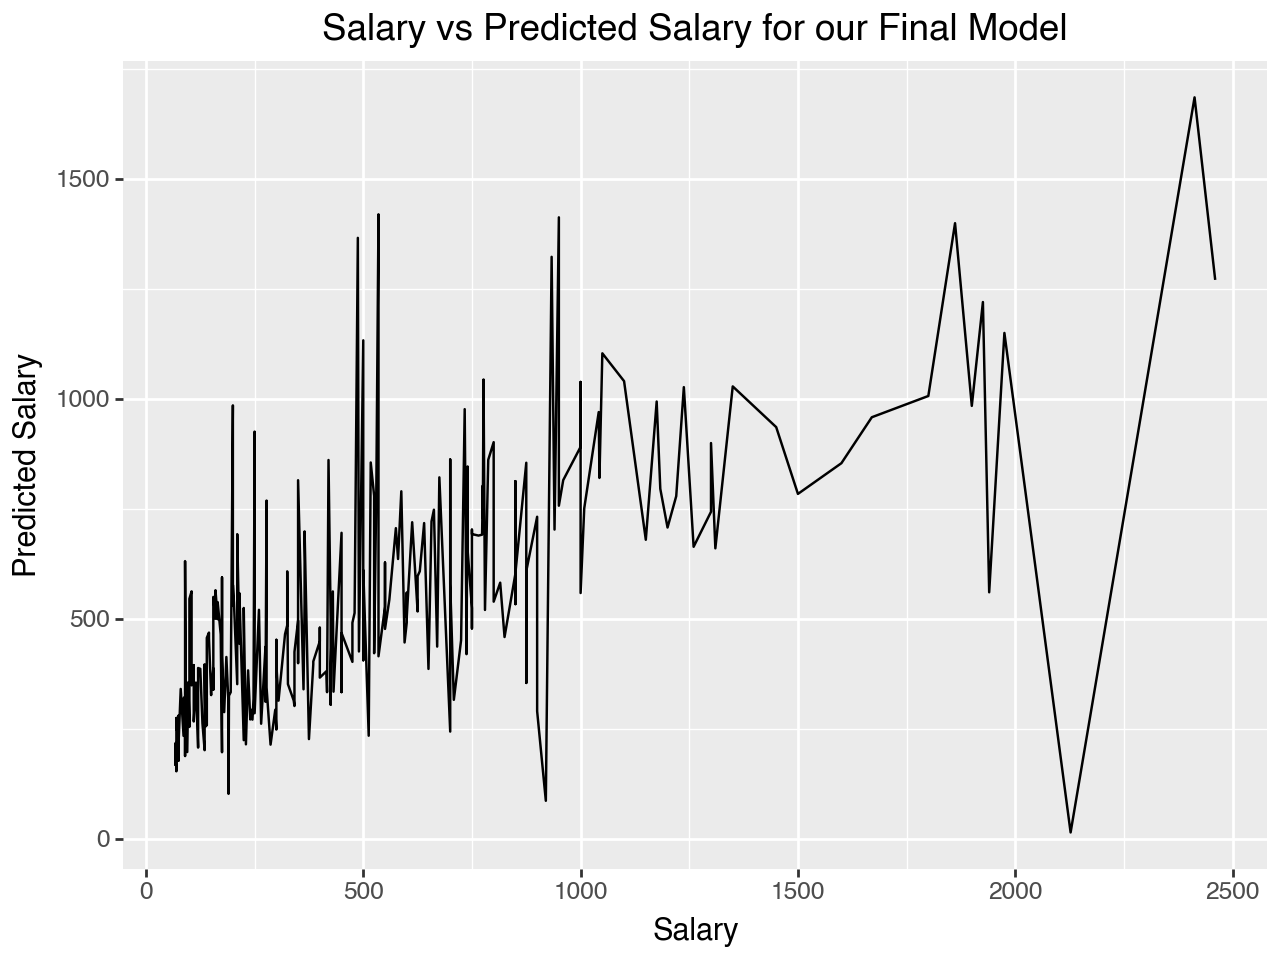

In [100]:
(pt.ggplot(baseball, pt.aes(x = "Salary", y="pred"))
 + pt.geom_line()
 +pt.labs(title="Salary vs Predicted Salary for our Final Model",
          x = "Salary",
          y = "Predicted Salary"))

Here, I have made a plot with Salary and Predicted Salary for the last model. The model has every variable as well as the interactions included in part 3. We can see that the model underestimated the high values of salary and overestimates the low values. From the graph, it looks like the model is overfitting based on all the variation in predicted values. The true best model would be one with fewer variables.

Chat GPT-4o was used to debug and to assist with the automation function.